In [1]:
import argparse
import importlib
import os
import time
from datetime import datetime
from functools import partial
from pathlib import Path

import cartopy.crs as ccrs
import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from geopy.distance import geodesic
from matplotlib.lines import Line2D
from mpl_toolkits import axes_grid1
from scipy.spatial import KDTree
from scipy.stats._continuous_distns import genpareto
from statsmodels.distributions.empirical_distribution import ECDF
from tqdm.auto import tqdm
from cartopy.mpl.ticker import (
    LatitudeFormatter,
    LatitudeLocator,
    LongitudeFormatter,
    LongitudeLocator,
)
import cartopy

import grapher

# Custom
import mstmeclass as mc
from mstmeclass import MSTME, SIMSET, STM, Area

pos_color = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.style.use("./src/plot_style.txt")

# Common

In [2]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

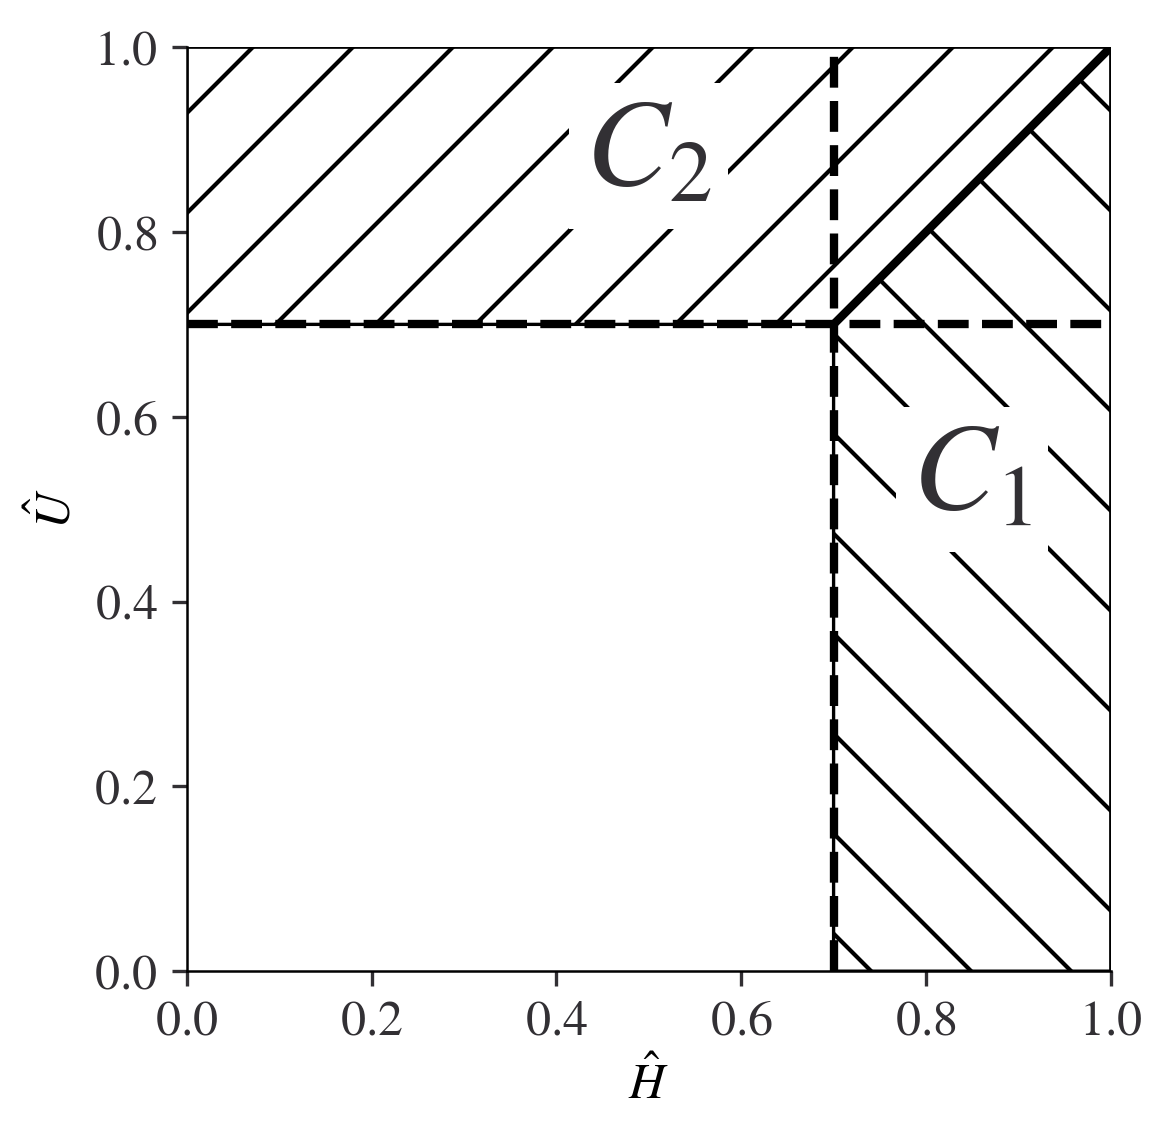

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), facecolor="white")
ax.set_aspect("equal")
ax.set_xlim(0.0, 1)
ax.set_ylim(0.0, 1)
thr = 0.7

##
patches = []
for i in range(2):
    polygon = Polygon(
        np.array(
            [
                [thr, thr],
                [1.0, 1.0],
                # [1.0 - (1.0 - thr) * i, thr + (1.0 - thr) * i],
                [1.0-i, i],
                [(thr)*(1.0-i), (thr) * i],
            ]
        ),
        closed=True,
        fill=False,
    )
    patches.append(polygon)
    patches[i].set(hatch=["\\", "/"][i])
ax.add_patch(patches[0])
ax.add_patch(patches[1])

##
x = np.linspace(thr, 1, 10)
ax.axhline(thr, linestyle="--", c="k")
ax.axvline(thr, linestyle="--", c="k")
ax.plot(x, x, c="k")
ax.set_xlabel("$\hat{H}$")
ax.set_ylabel("$\hat{U}$")
ax.text(
    0.85,
    0.50,
    "$C_1$",
    fontsize=30,
    ha="center",
    bbox=dict(facecolor="white", lw=0),
)
ax.text(
    0.50,
    0.85,
    "$C_2$",
    fontsize=30,
    ha="center",
    bbox=dict(facecolor="white", lw=0),
)
plt.savefig(
    Path("./output/common/active/conmul_region_illustration.pdf"), bbox_inches="tight"
)
plt.savefig(
    Path("./output/common/active/conmul_region_illustration.png"), bbox_inches="tight"
)

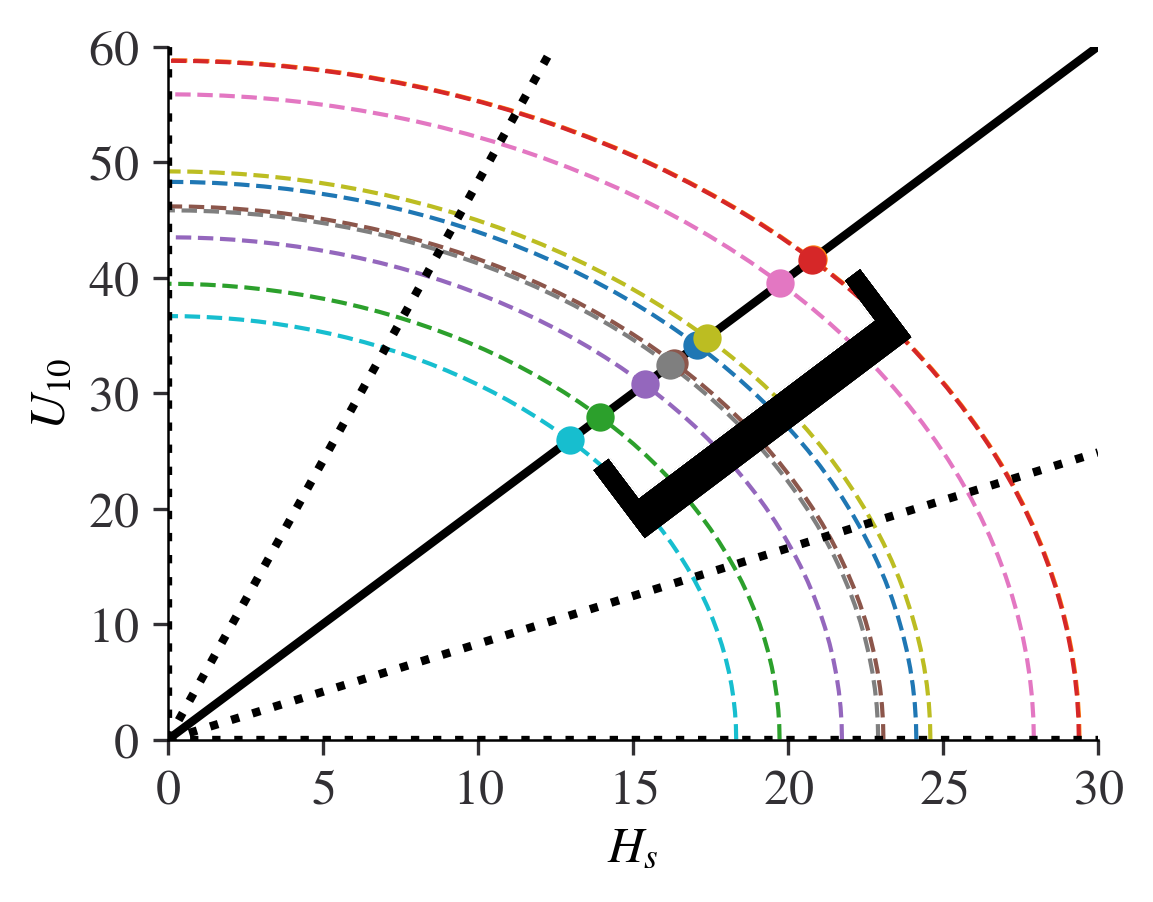

In [4]:
fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.set_xlim(0,30)
ax.set_ylim(0,60)
ax.set_xlabel(STM.H.name())
ax.set_ylabel(STM.U.name())
rng = np.random.default_rng(1)
radii = 0.6+0.4*rng.random(size=10)
for r in radii:
    x=[30*r*np.cos(theta) for theta in np.linspace(0,np.pi/2)]
    y=[60*r*np.sin(theta) for theta in np.linspace(0,np.pi/2)]
    ax.plot(x,y,ls='--',lw=1)
for i,theta in enumerate(np.linspace(0,np.pi/2,5,endpoint=True)):
  x = np.linspace(0,30)
  y = 2*np.tan(theta)*x
  if i ==2:
    ls = '-'
  else:
     ls=':'
  ax.plot(x,y,c='black',ls=ls)
  if i==2:
    for r in radii:
       plt.scatter(30*r*np.cos(theta),60*r*np.sin(theta),zorder=10)
  ax.text(14,26,']',fontfamily='serif',color="black",size=90,rotation=-53,rotation_mode='anchor')

plt.savefig(
    Path("./output/common/active/contour_ci_illustration.pdf"), bbox_inches="tight"
)
plt.savefig(
    Path("./output/common/active/contour_ci_illustration.png"), bbox_inches="tight"
)

In [5]:
import importlib

In [6]:
importlib.reload(grapher)

<module 'grapher' from 'J:\\mstme\\src\\grapher.py'>

In [7]:
def custom_map(
    ax,
    area: Area,
):
    ax.add_feature(cartopy.feature.LAND, edgecolor="black")
    ax.coastlines()
    ax.yaxis.tick_right()
    # ax.set_xticks(
    #     create_custom_ticks(area.min_lon, area.max_lon, 0.5),
    #     crs=ccrs.PlateCarree(),
    #     rotation=45,
    # )
    # ax.set_yticks(
    #     create_custom_ticks(area.min_lat, area.max_lat, 0.5), crs=ccrs.PlateCarree()
    # )
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim(area.min_lon, area.max_lon)
    ax.set_ylim(area.min_lat, area.max_lat)
    return ax

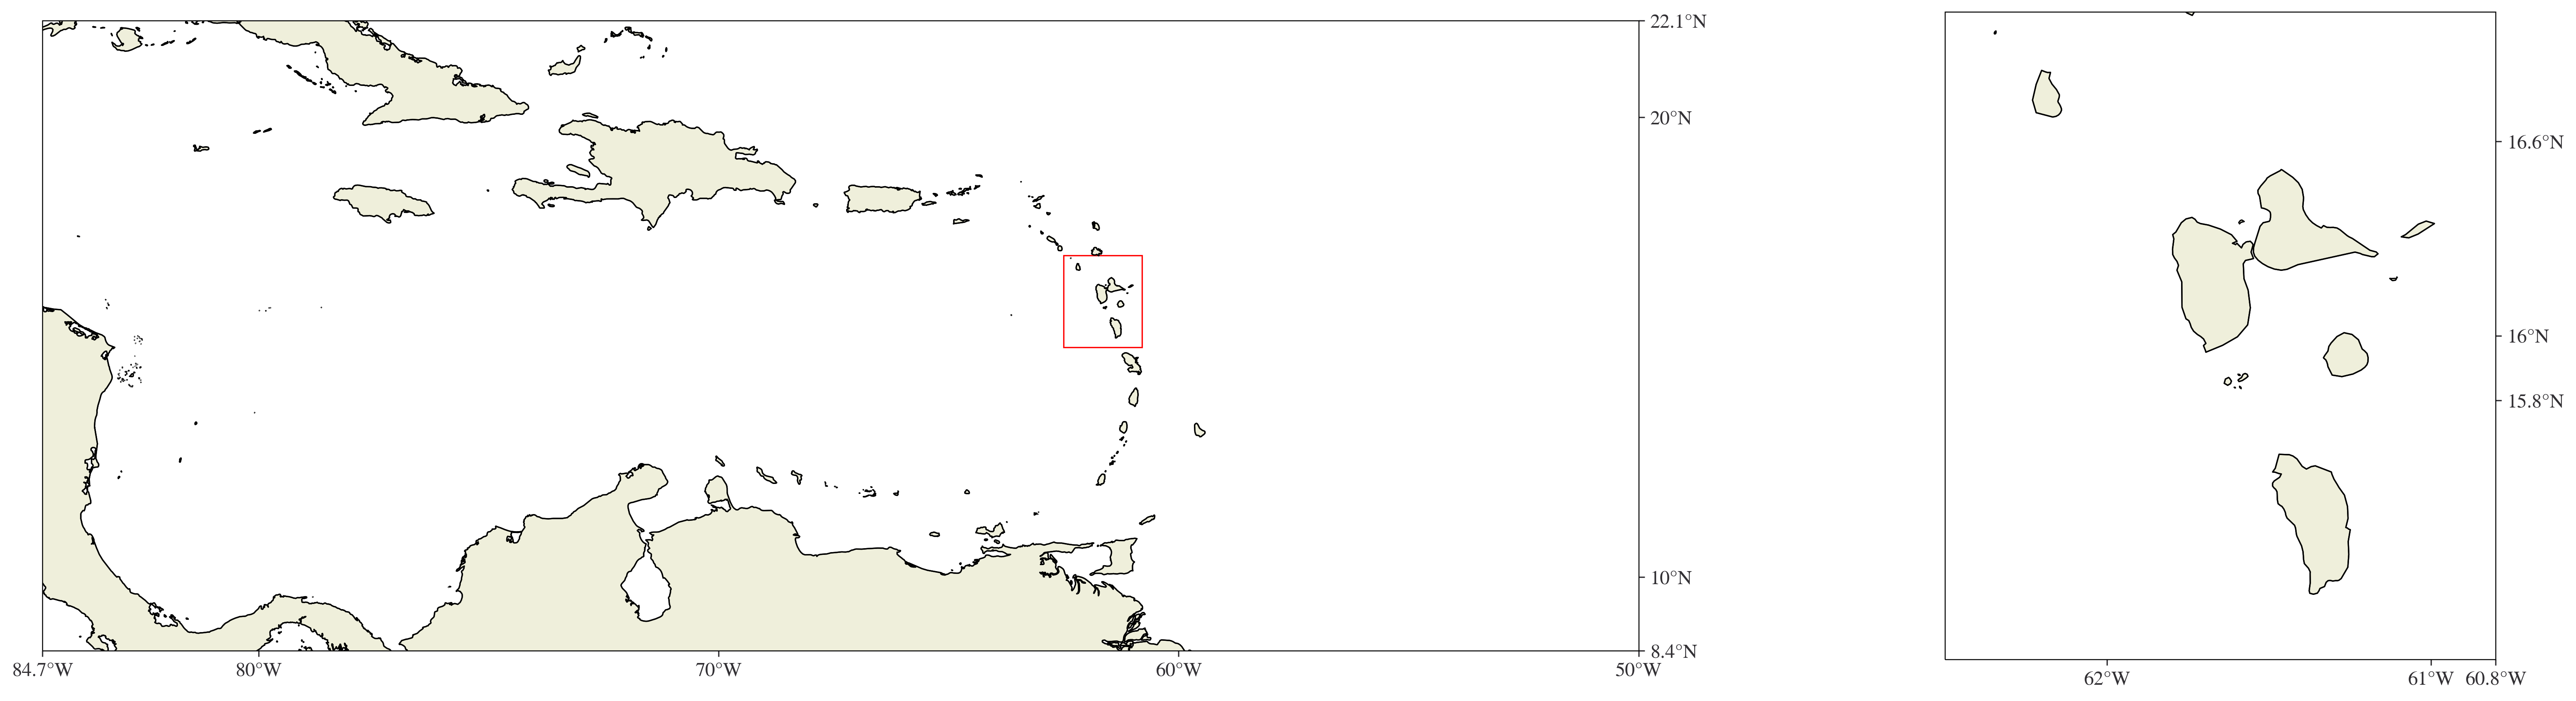

In [14]:
from matplotlib.patches import Rectangle
fig, axes = plt.subplots(
    1,
    2,
    figsize=(8 * 3.2, 6),
    facecolor="white",
    subplot_kw={"projection": ccrs.PlateCarree()},
)
xticks = [[-84.7, -80, -70, -60, -50], [-62.0, -61, -60.8]]
yticks = [[8.4, 10, 20, 22.1], [15.80, 16, 16.6]]
areas = [
    Area(
        min_lon=-84.70,
        max_lon=-50.00,
        min_lat=8.40,
        max_lat=22.10,
    ),
    Area(
        min_lon=-62.50,
        min_lat=15.00,
        max_lon=-60.80,
        max_lat=17.00,
    ),
]
for vi in range(2):
    ax = axes[vi]
    ax = custom_map(
        ax,
        areas[vi],
    )
    ax.set_xticks(xticks[vi], crs=ccrs.PlateCarree())
    ax.set_yticks(yticks[vi], crs=ccrs.PlateCarree())
    # ax.set_xticks(rotation=45)

axes[0].add_patch(Rectangle((-62.5,15.0),1.7,2.0,edgecolor='red',fill=False))
plt.tight_layout()

# axes[0].add_patch(Rectangle((-65,12),7,6,edgecolor='black',fill=False))
plt.savefig(Path('./output/common/active/map.pdf'),bbox_inches='tight')
plt.savefig(Path('./output/common/active/map.png'),bbox_inches='tight')

# Load data

In [20]:
preset = 3
match preset:
    case 0:
        region = "guadeloupe"
        N_subsample = 100
        rf = "h-east"
        RECALC = False
        thr_pct_mar = 0.6
        thr_pct_com = 0.9
    case 1:
        region = "guadeloupe"
        N_subsample = 100
        rf = "h-west"
        RECALC = False
        thr_pct_mar = 0.6
        thr_pct_com = 0.65
    case 2:
        region = "guadeloupe-wide"
        N_subsample = 100
        rf = "h-east"
        RECALC = True
        thr_pct_mar = 0.6
        thr_pct_com = 0.9
        thr_mar_list = [
            0.6,
            0.65,
            0.70,
            0.75,
            0.80,
            # 0.85,
            # 0.90,
        ]
        thr_com_list = [
            0.60,
            # 0.65,
            0.70,
            # 0.75,
            0.80,
            # 0.85,
            0.90
        ]
    case 3:
        region = "guadeloupe-wide"
        N_subsample = 100
        rf = "h-west"
        RECALC = True
        thr_pct_mar = 0.6
        thr_pct_com = 0.70
        thr_mar_list = [
            0.6,
            0.65,
            0.70,
            0.75,
            0.80,
            # 0.85,
            # 0.90,
        ]
        thr_com_list = [
            0.60,
            # 0.65,
            0.70,
            # 0.75,
            0.80,
            # 0.85,
            0.90
        ]

In [21]:
path_notebook = Path(f"notebook_{region}_{rf}.dill")
if path_notebook.exists() and not RECALC:
    with open(path_notebook, "rb") as f:
        dill.load_session(f)
else:
    columns = [
        "thr_mar_pct",
        "thr_com_pct",
        "thr_mar",
        "thr_com",
        "count",
        "kt_fail_ratio",
        "shape_param",
    ]
    data = []
    clusters = []



    for i, thr_pct_mar in enumerate(thr_mar_list):
        for j, thr_pct_com in enumerate(thr_com_list):
            path = Path(
                f"./output-new/{region}/{rf}/GP{round(thr_pct_mar*100)}%_CM{round(thr_pct_com*100)}%_{N_subsample}subsamples/mstme_condition.dill"
            )
            with open(path, "rb") as f:
                try:
                    cluster: MSTME = dill.load(f)
                except:
                    print(thr_pct_mar, thr_pct_com)
                    continue
                # if cluster.thr_pct_com in [0.90, 0.95]:
                #     continue
                # elif cluster.thr_pct_mar:
                #     continue
                clusters.append(cluster)
                if i == 0 and j == 0:
                    tree = KDTree(cluster.latlon)
                    grid_res = 10
                    lat_list = np.linspace(
                        cluster.area.min_lat, cluster.area.max_lat, grid_res
                    )
                    lon_list = np.linspace(
                        cluster.area.min_lon, cluster.area.max_lon, grid_res
                    )
                    dist_list, pos_list = tree.query(
                        [[[lat, lon] for lat in lat_list] for lon in lon_list]
                    )
                    pos_list = pos_list.flatten()
                    pos_list = np.unique(pos_list)
                if not hasattr(cluster, "pval"):
                    cluster.calc_kendall_tau()
                print(
                    f"{cluster.thr_pct_mar}\t{cluster.thr_pct_com}\t{cluster.thr_mar}\t{cluster.thr_com}\t{np.count_nonzero(cluster.is_e,axis=1)}"
                )

            with open(path, "wb") as f:
                dill.dump(cluster, f)
    cl_arr = np.array(clusters, dtype=MSTME).reshape(
        (len(thr_mar_list), len(thr_com_list))
    )

0.6	0.6	[ 6.96999979 26.36199875]	0.2998622643424505	[80 79]
0.6	0.7	[ 6.96999979 26.36199875]	0.5509482943087708	[63 58]
0.6	0.8	[ 6.96999979 26.36199875]	1.019621970376207	[36 39]
0.6	0.9	[ 6.96999979 26.36199875]	1.9384625487383524	[18 16]
0.65	0.6	[ 7.52399998 28.07299967]	0.31438480915211975	[80 80]
0.65	0.7	[ 7.52399998 28.07299967]	0.5601562660622061	[62 59]
0.65	0.8	[ 7.52399998 28.07299967]	1.005888925695735	[36 39]
0.65	0.9	[ 7.52399998 28.07299967]	1.9130935377503537	[18 16]
0.7	0.6	[ 8.13399944 29.47899971]	0.31438480915211975	[80 80]
0.7	0.7	[ 8.13399944 29.47899971]	0.5580804238932114	[62 59]
0.7	0.8	[ 8.13399944 29.47899971]	0.9644865751424755	[37 38]
0.7	0.9	[ 8.13399944 29.47899971]	1.8314132867040969	[18 16]
0.75	0.6	[ 9.14249992 31.70249891]	0.31438480915211975	[80 80]
0.75	0.7	[ 9.14249992 31.70249891]	0.612129726491786	[60 60]
0.75	0.8	[ 9.14249992 31.70249891]	0.9917927406665089	[36 39]
0.75	0.9	[ 9.14249992 31.70249891]	1.8456497690608704	[19 14]
0.8	0.6	[ 9.7299

In [22]:
dir_out = Path(f"./output-new/{region}/summary/{rf}")
if not dir_out.exists():
    dir_out.mkdir(parents=True, exist_ok=True)

# Marginal threshold choice

## Convex hull of a,b over marginal thresholds

In [23]:
from scipy.spatial import ConvexHull
viridis = plt.colormaps['viridis']

def remap(x, in_min, in_max, out_min, out_max):
  return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

0.6 0.6
0.65 0.6
0.7 0.6
0.75 0.6
0.8 0.6
0.6 0.7
0.65 0.7
0.7 0.7
0.75 0.7
0.8 0.7
0.6 0.8
0.65 0.8
0.7 0.8
0.75 0.8
0.8 0.8
0.6 0.9
0.65 0.9
0.7 0.9
0.75 0.9
0.8 0.9


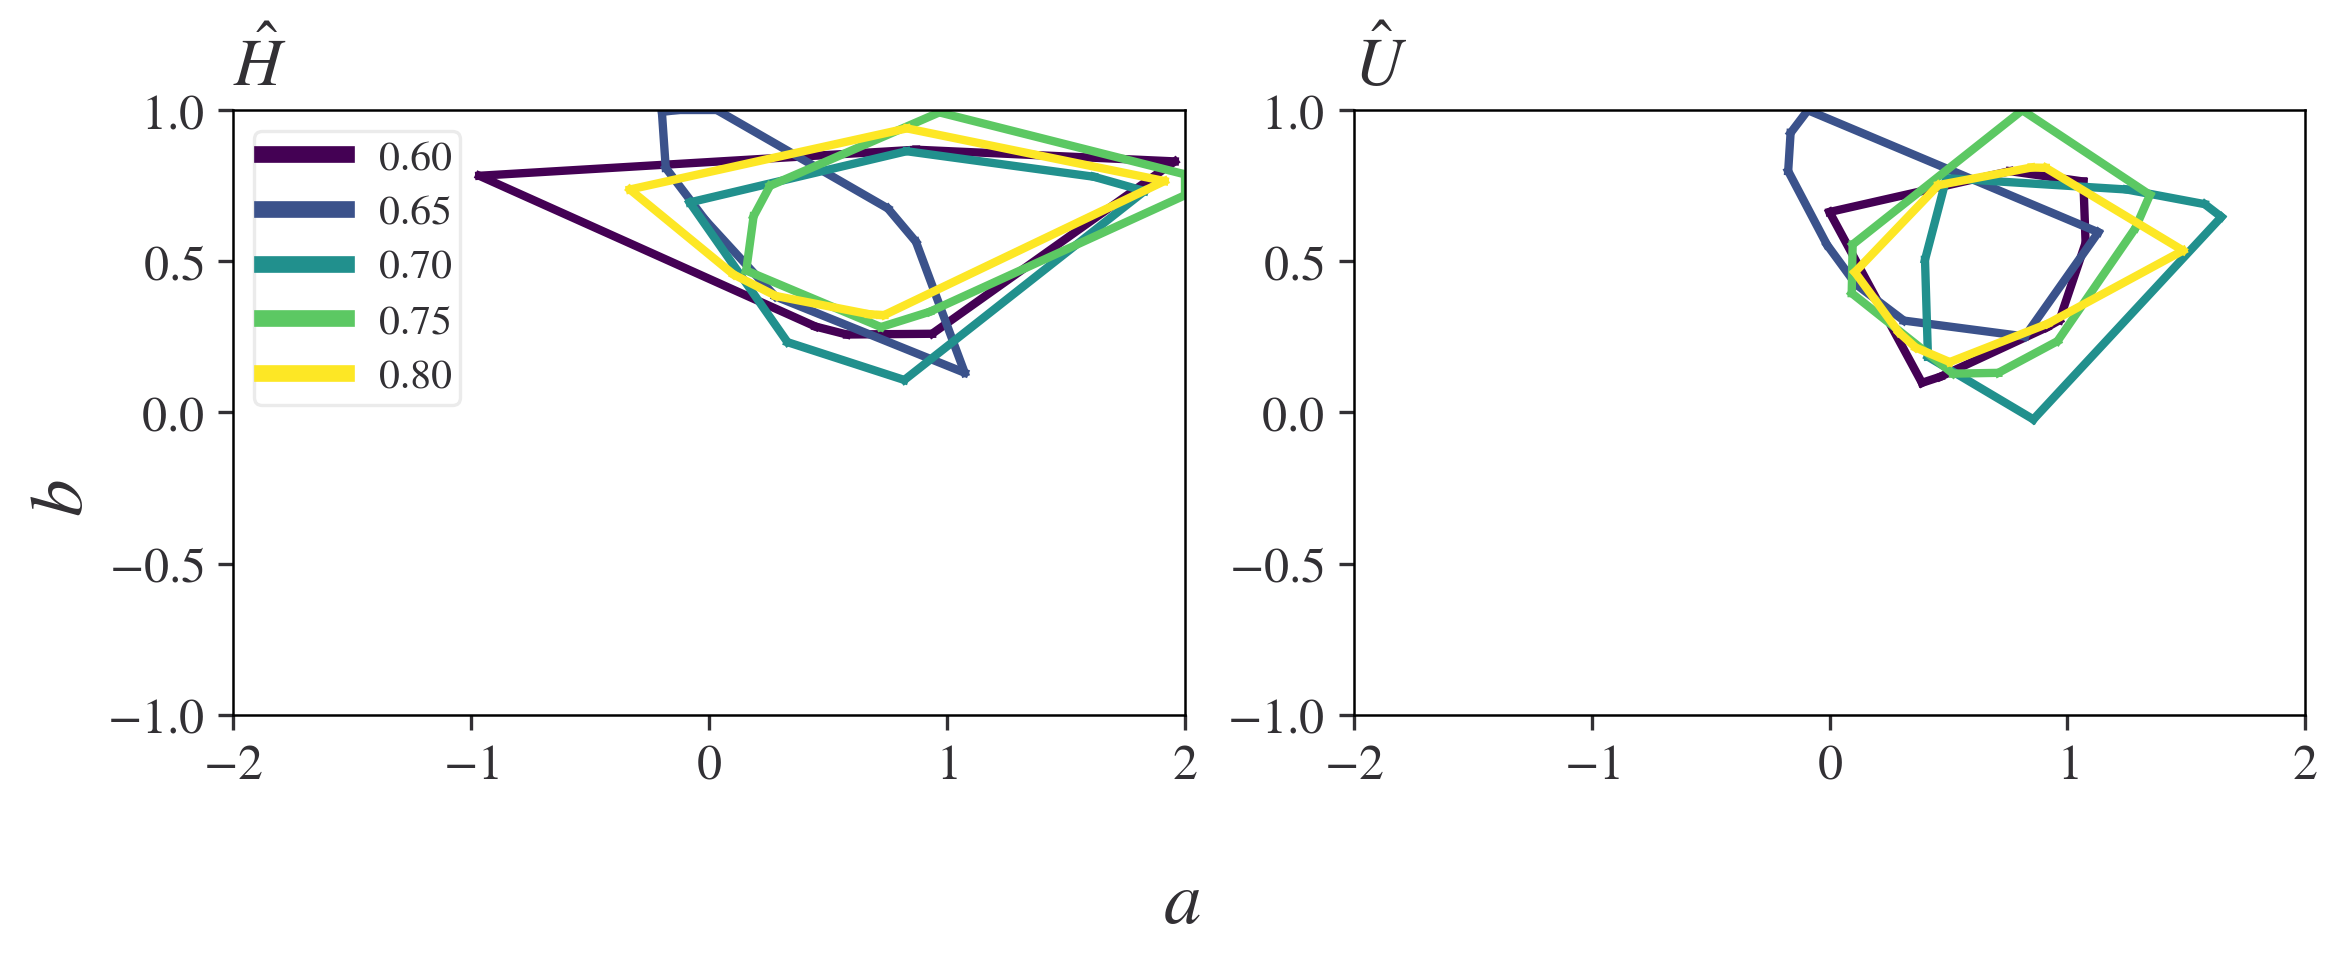

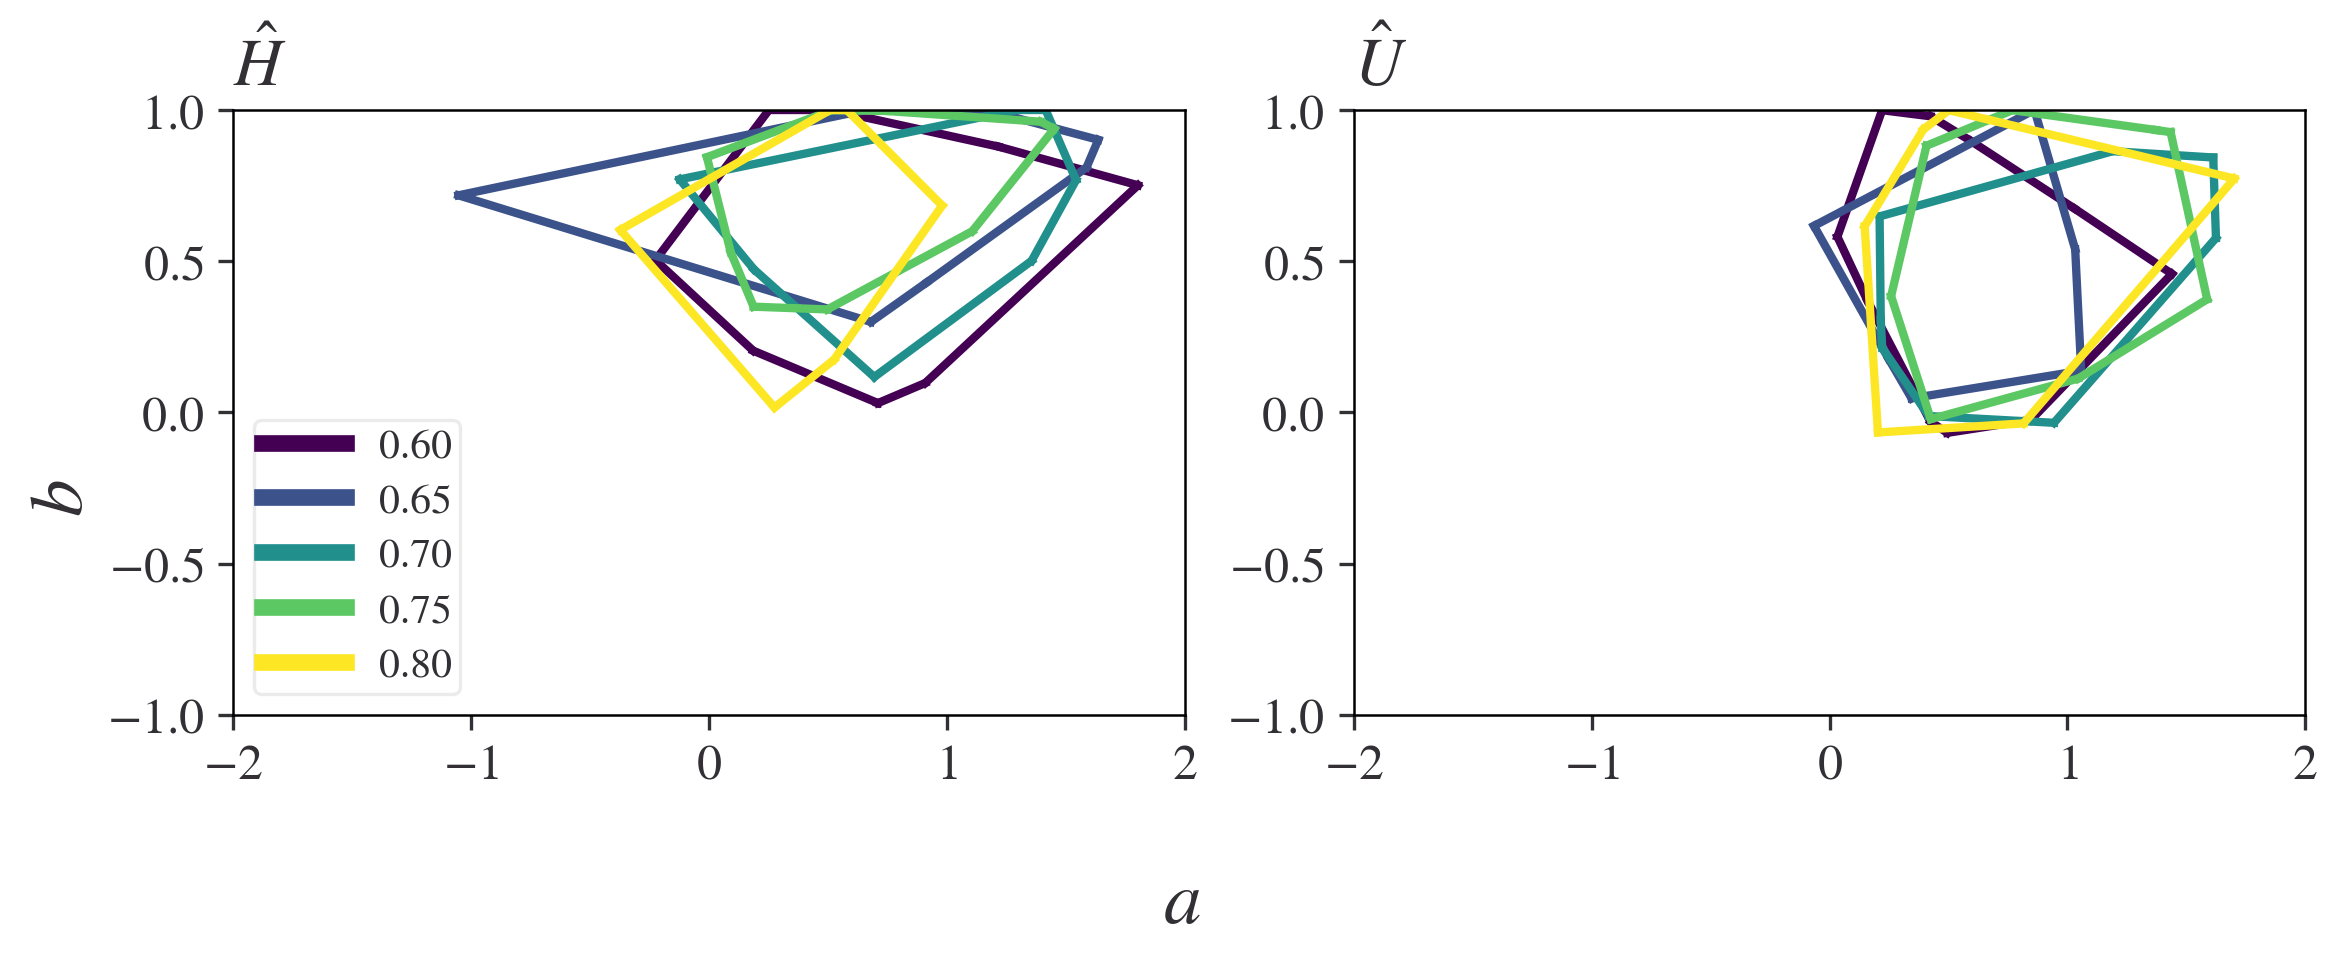

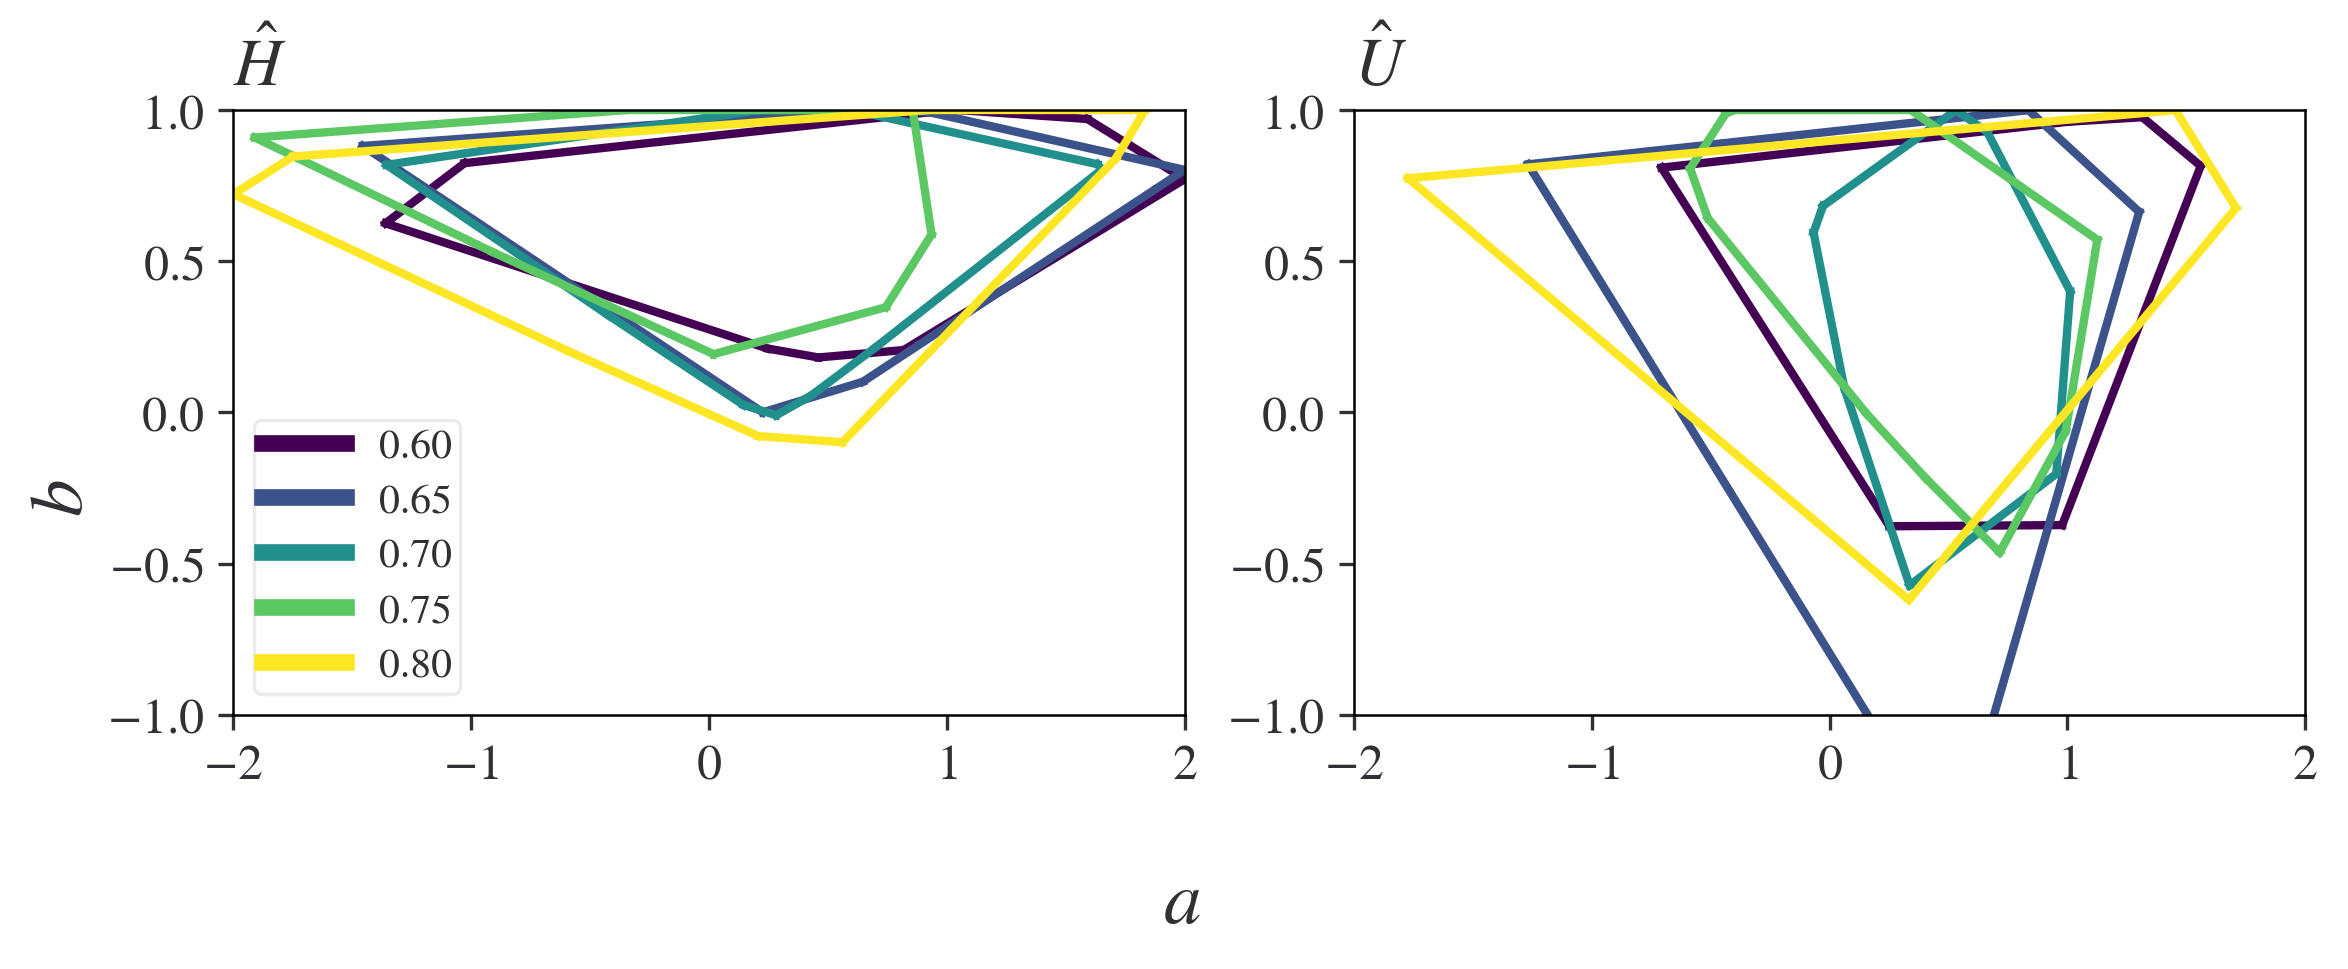

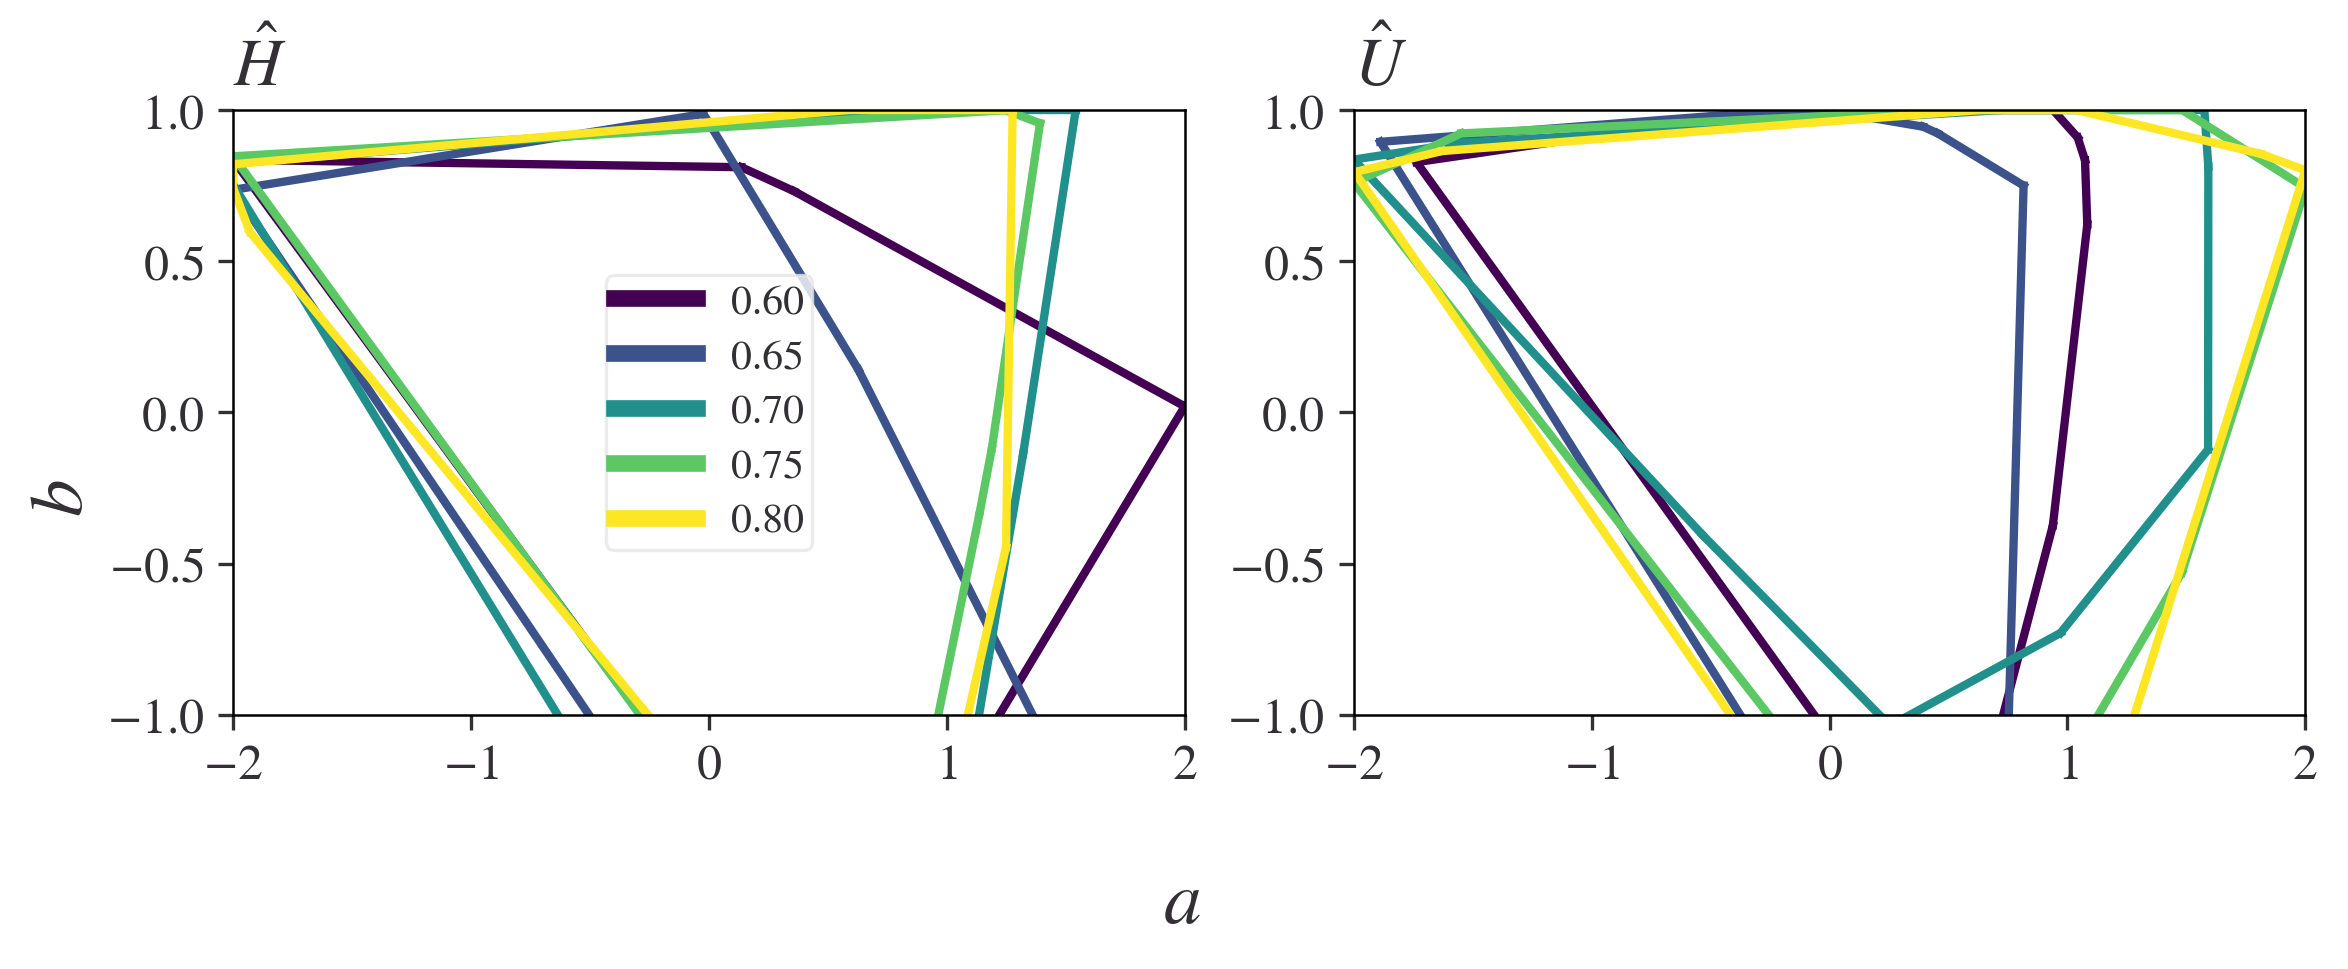

In [24]:
for idx in range(cl_arr.shape[1]):
  fig, ax = plt.subplots(1,2, figsize=(8, 3))
  fig.supxlabel("$a$")
  fig.supylabel("$b$")
  # fig.suptitle(f"Convex hull of parameter estimates over marginal thresholds 0.6~0.80, common threshold = {cl_arr[0,idx].thr_pct_com}",size=10,y=1.05)
  fig.tight_layout()
  custom_lines = []
  thr_mar_list = []

  for cl in cl_arr[:, idx]:
    print(cl.thr_pct_mar, cl.thr_pct_com)
    thr_mar_list.append(cl.thr_pct_mar)
    thr_mar_norm = remap(cl.thr_pct_mar,0.6,0.80,0,1)
    custom_lines.append(Line2D([0], [0], color=viridis(thr_mar_norm), lw=4))
    for S in STM:
      vi=S.idx()
      ax[vi].set_xlim(-2, 2)
      ax[vi].set_ylim(-1, 1)
      ax[vi].set_title(S.name_norm())
      points = np.array([cl.params_uc[vi,:,0],cl.params_uc[vi,:,1]]).T
      hull = ConvexHull(points)
      for simplex in hull.simplices:
        ax[vi].plot(points[simplex, 0], points[simplex, 1], c=viridis(thr_mar_norm))
  ax[0].legend(custom_lines, [f'{thr:.2f}'for thr in thr_mar_list])
  plt.savefig(dir_out/f"convex_hull_marginal_CM{cl_arr[0,idx].thr_pct_com*100:.0f}.png", bbox_inches="tight")
  plt.savefig(dir_out/f"convex_hull_marginal_CM{cl_arr[0,idx].thr_pct_com*100:.0f}.pdf", bbox_inches="tight")


# Dependency threshold choice

## Load data (only at one marginal threshold)

In [25]:
thr_pct_mar = 0.6

In [26]:
if path_notebook.exists() and not RECALC:
    pass
else:
    cl_list = []
    for i, path in enumerate(
        Path(f"./output-new/{region}/{rf}").glob(
            f"GP{round(thr_pct_mar*100)}%_CM*%_{N_subsample}subsamples/mstme_condition.dill"
        )
    ):
        with open(path, "rb") as f:
            cluster: MSTME = dill.load(f)
            cl_list.append(cluster)
            if i==0:
                tree = KDTree(cluster.latlon)
                grid_res = 10
                lat_list = np.linspace(cluster.area.min_lat, cluster.area.max_lat, grid_res)
                lon_list = np.linspace(cluster.area.min_lon, cluster.area.max_lon, grid_res)
                dist_list, pos_list = tree.query([[[lat, lon] for lat in lat_list] for lon in lon_list])
                pos_list = pos_list.flatten()
                pos_list = np.unique(pos_list)
            if not hasattr(cluster, "pval"):
                cluster.calc_kendall_tau()


## count

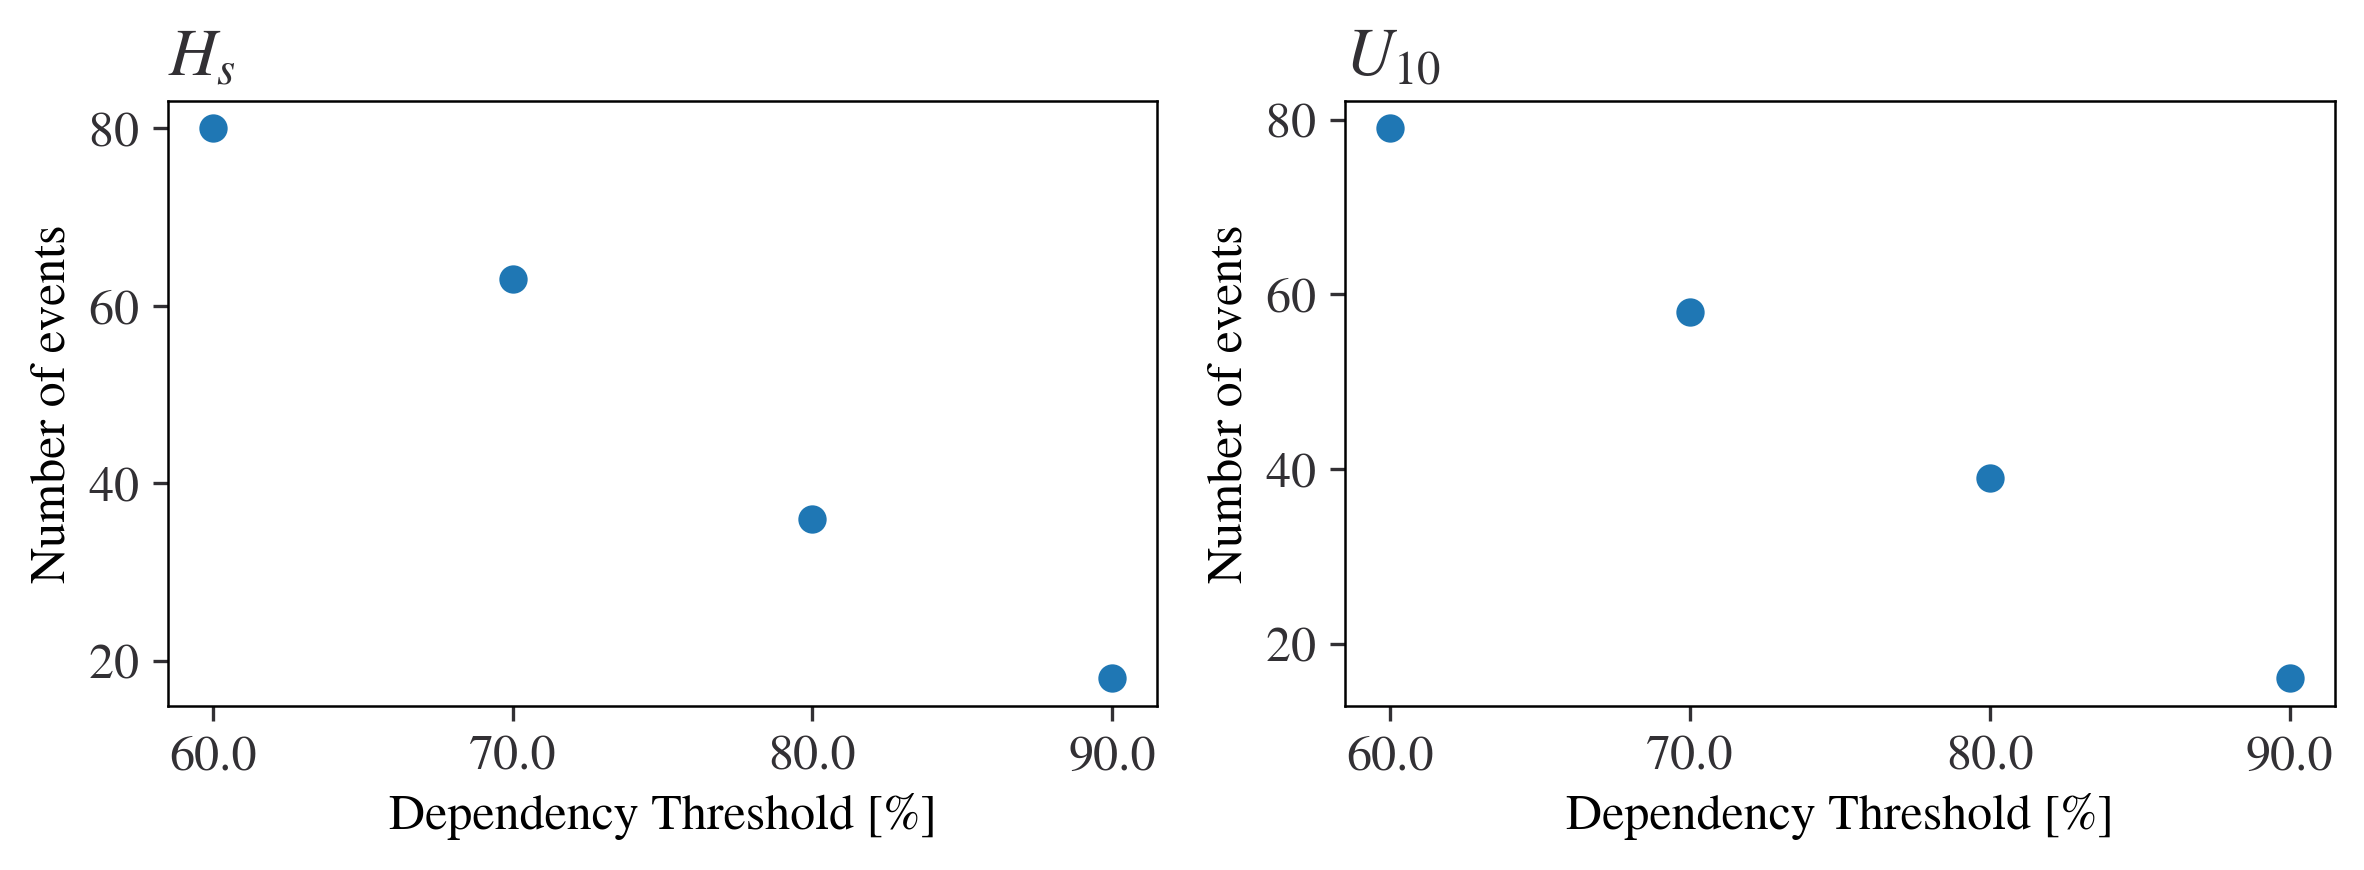

In [27]:
count = []
thr = []
for cl in cl_list:
    thr.append(cl.thr_pct_com*100) 
    count.append(np.count_nonzero(cl.is_e,axis=1))

count=np.array(count)

fig,ax= plt.subplots(1,2,figsize=(4*2,3))
for S in STM:
    vi = S.idx()
    ax[vi].set_title(f"{S.name()}")
    ax[vi].set_xlabel("Dependency Threshold [%]")
    ax[vi].set_ylabel("Number of events")
    ax[vi].set_xticks(thr, labels=thr)
    ax[vi].scatter(thr,count[:,vi])

        
fig.tight_layout()
plt.savefig(dir_out/f"number_of_events_GP{thr_pct_mar*100:.0f}.png", bbox_inches="tight")
plt.savefig(dir_out/f"number_of_events_GP{thr_pct_mar*100:.0f}.pdf", bbox_inches="tight")


## Convex hull

0.6 0.6
0.6 0.7
0.6 0.8
0.6 0.9


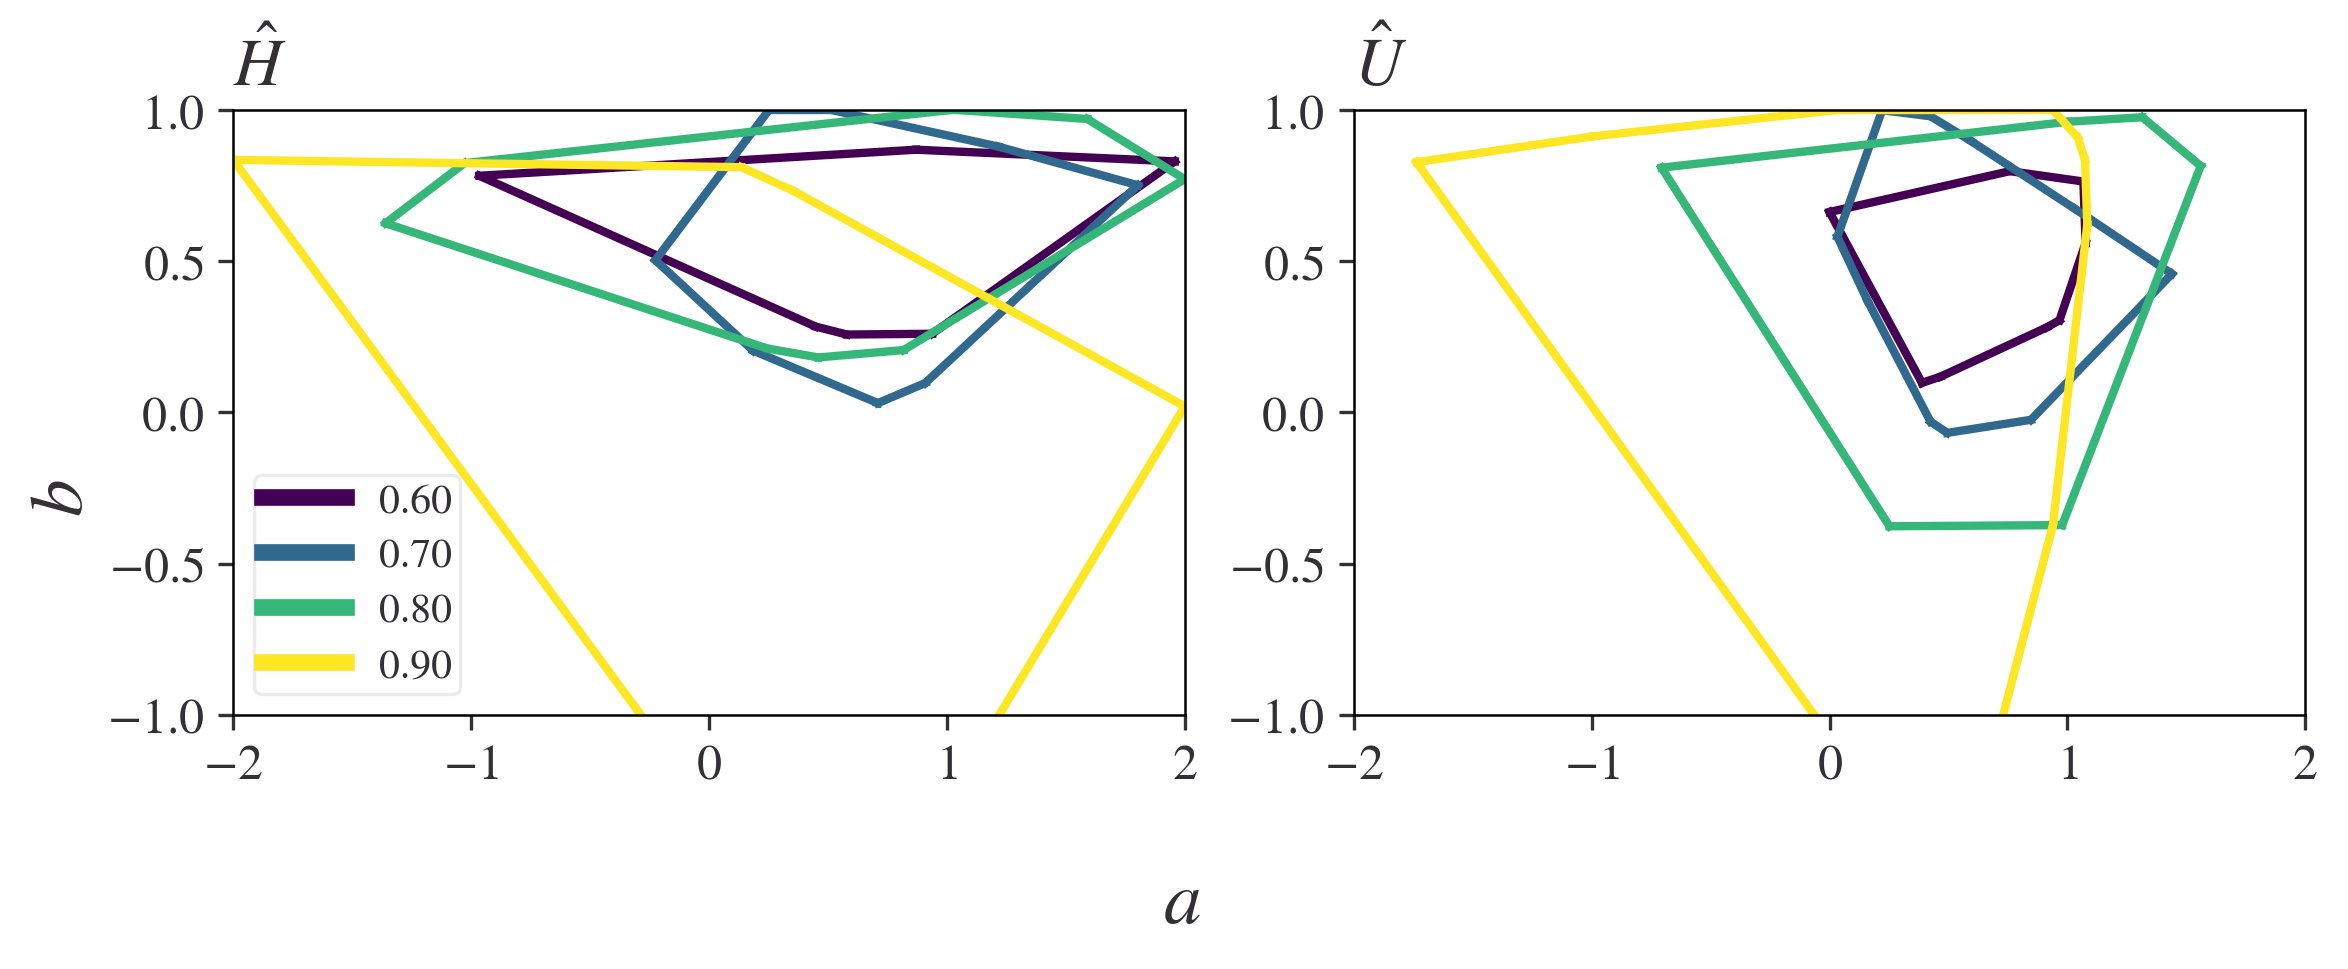

In [28]:
fig, ax = plt.subplots(1,2, figsize=(8, 3))
fig.supxlabel("$a$")
fig.supylabel("$b$")
# fig.suptitle("Convex hull of parameter estimates over common thresholds 0.6~0.85 (Marginal=0.60)",size=10,y=1.05)
fig.tight_layout()

custom_lines = []
thr_com_list = []

for i,cl in enumerate(cl_list):
  print(cl.thr_pct_mar, cl.thr_pct_com)
  thr_com_list.append(cl.thr_pct_com)
  thr_com_norm = remap(cl.thr_pct_com,0.6,0.9,0,1)
  custom_lines.append(Line2D([0], [0], color=viridis(thr_com_norm), lw=4))
  for S in STM:
    vi=S.idx()
    ax[vi].set_xlim(-2, 2)
    ax[vi].set_ylim(-1, 1)
    ax[vi].set_title(S.name_norm())
    points = np.array([cl.params_uc[vi,:,0],cl.params_uc[vi,:,1]]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
      ax[vi].plot(points[simplex, 0], points[simplex, 1], c=viridis(thr_com_norm))

ax[0].legend(custom_lines, [f'{thr:.2f}'for thr in thr_com_list])
plt.savefig(dir_out/f"convex_hull_conditional_GP{thr_pct_mar*100:.0f}.png", bbox_inches="tight")
plt.savefig(dir_out/f"convex_hull_conditional_GP{thr_pct_mar*100:.0f}.pdf", bbox_inches="tight")

## kt fail ratio

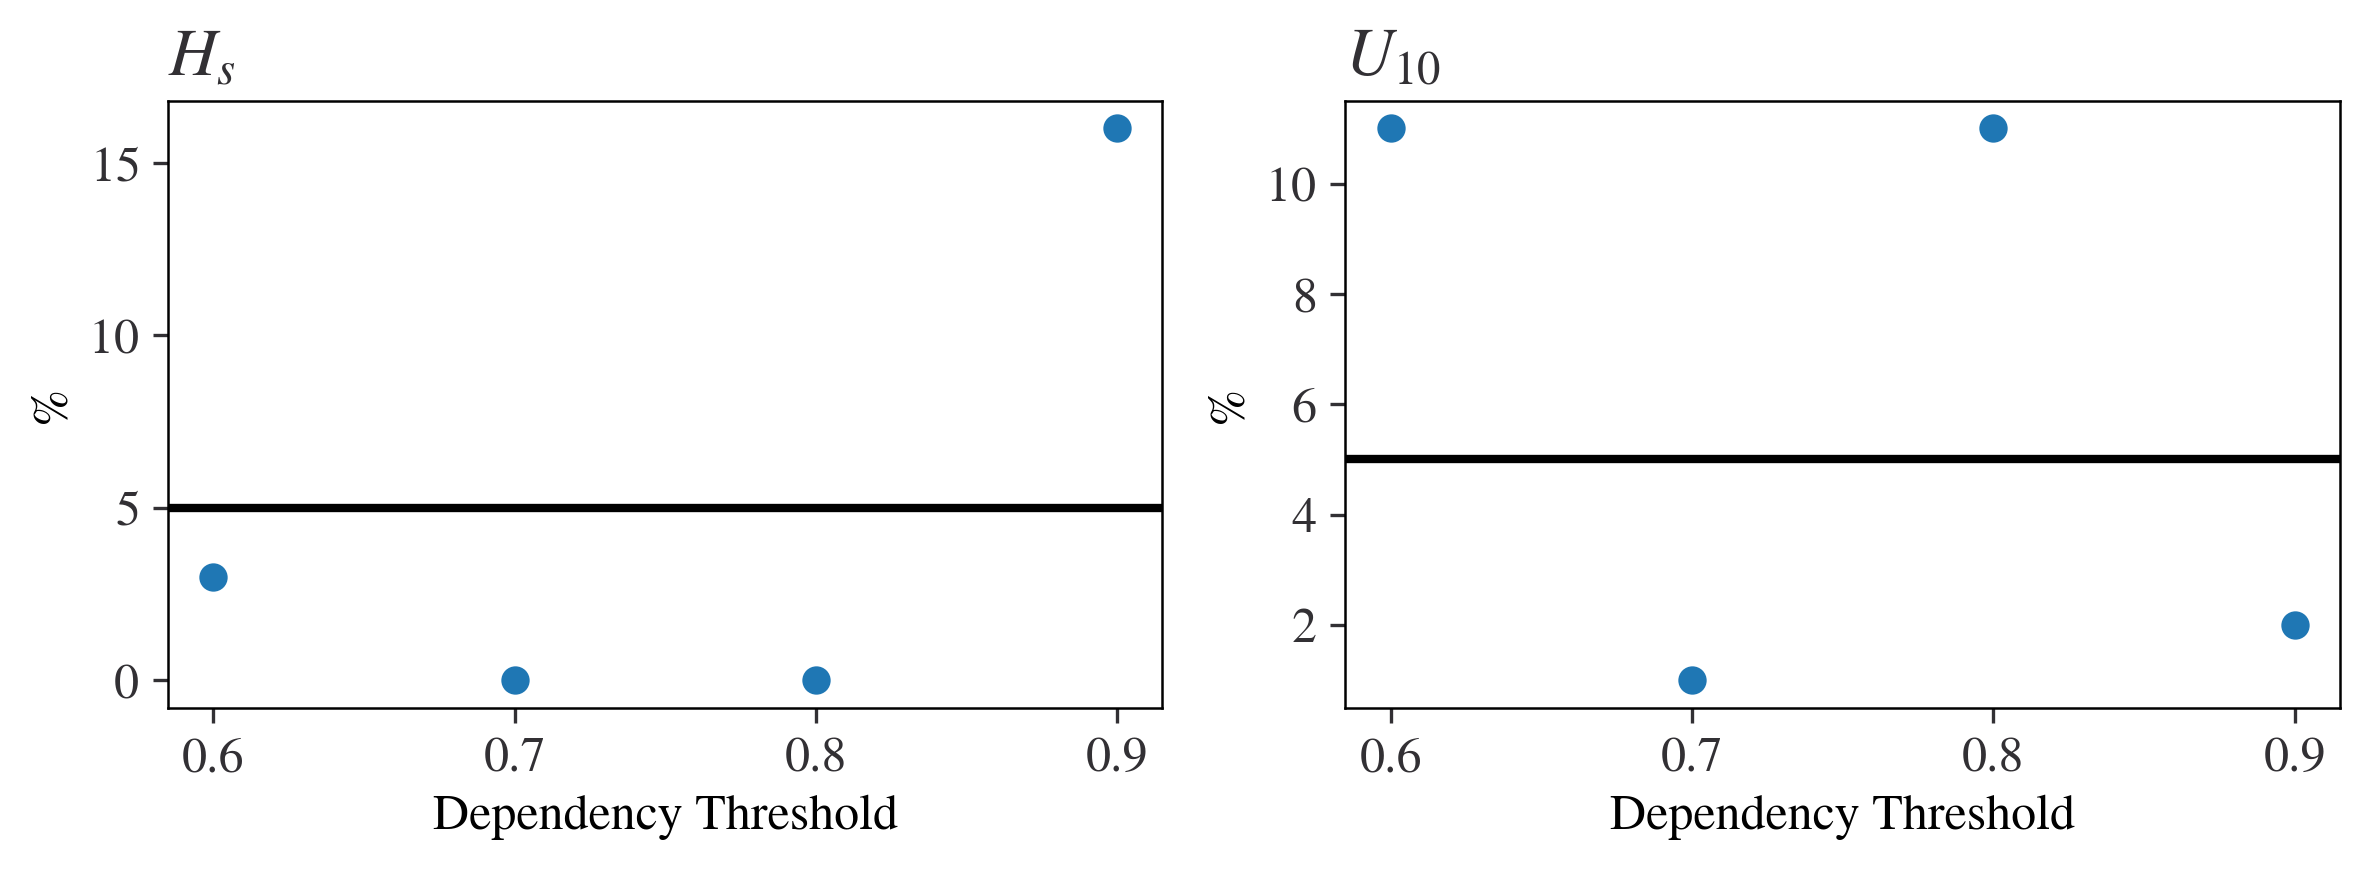

In [29]:
kt_fail_ratio = []
thr = []
for cl in cl_list:
    thr.append(cl.thr_pct_com)
    kt_fail_ratio.append(np.count_nonzero(cl.pval[:, :, pos_list] < 0.05, axis=2)
                    / pos_list.size)

kt_fail_ratio=np.array(kt_fail_ratio)

fig,ax= plt.subplots(1,2,figsize=(4*2,3))
for S in STM:
    vi = S.idx()
    ax[vi].set_title(f"{S.name()}")
    ax[vi].set_xlabel("Dependency Threshold")
    ax[vi].set_ylabel("%")
    ax[vi].set_xticks(thr, labels=thr)
    ax[vi].axhline(5,c='k',zorder=-1)
    ax[vi].scatter(thr,kt_fail_ratio[:,vi,vi]*100)

        
fig.tight_layout()
plt.savefig(dir_out/f"kt_fail_ratio_GP{thr_pct_mar*100:.0f}.png", bbox_inches="tight")
plt.savefig(dir_out/f"kt_fail_ratio_GP{thr_pct_mar*100:.0f}.pdf", bbox_inches="tight")

## shape param

In [25]:
# data = np.stack(df['shape_param'].values).reshape((5,6,2))[:,:,0]
# x=[0.60,0.65,0.70,0.75,0.80,0.85]
# y=[0.60,0.65,0.70,0.75,0.80]

# fig,ax= plt.subplots(1,1,figsize=(4,4))
# ax.set_title("Estimated shape parameter of GPD ($H_s$)",size=10)
# ax.set_xlabel("Dependency Threshold [%]")
# ax.set_ylabel("Marginal Threshold [%]")
# ax.set_xticks(np.arange(len(x)), labels=x)
# ax.set_yticks(np.arange(len(y)), labels=y)
# ax.tick_params(top=True, bottom=False,
#                    labeltop=True, labelbottom=False)
# ax.xaxis.set_label_position('top')
# im=ax.imshow(
#       data,
#       origin='upper',
#     )

# for i in range(len(x)):
#     for j in range(len(y)):
#         text = ax.text(i, j, f"{data[j, i]:.2f}",
#                        ha="center", va="center", color="w")
        
# fig.tight_layout

# Dump

In [17]:
with open(path_notebook,'wb') as f:
    dill.dump_session(f)

# stuff

In [ ]:
def draw_rv(mstme:MSTME,tm_MSTME_ss,**kwargs):
    grid_res = 11
    mstme = mstme
    area = mstme.area
    lat_list = np.linspace(area.min_lat, area.max_lat, grid_res)
    lon_list = np.linspace(area.min_lon, area.max_lon, grid_res)
    dist_list, pos_list = mstme.tree.query(
        [[[lat, lon] for lat in lat_list] for lon in lon_list]
    )
    pos_list = pos_list.flatten()
    tm_MSTME_ss_norm = np.empty(tm_MSTME_ss.shape[:3]+(len(pos_list),))  # (ss,v,e,n)
    tm_original = mstme.tm  # (v,e,n)
    for S in STM:
        vi = S.idx()
        tm_MSTME_ss_norm[:, vi, :, :] = mstme.ndist.ppf(
            mstme.mix_dist[vi].cdf(tm_MSTME_ss[:, vi, :][:,:,pos_list])
        )
    # bi, ni, vi, ei
    return_period = kwargs.get("return_period")

    N_subsample = tm_MSTME_ss_norm.shape[0]
    _num_events_sample = tm_MSTME_ss_norm.shape[2]
    _exceedance_prob = 1 - mstme.thr_pct_com

    l_array_MSTME = []
    l_array_original = []
    for i,ni in enumerate(pos_list):
        print(i)
        # Sample count over threshold
        _count_sample = round(
            _num_events_sample
            / (return_period * mstme.occur_freq * _exceedance_prob)
        )
        _ic_original = []
        _num_events_original = tm_original.shape[1]
        _count_original = round(
            _num_events_original / (return_period * mstme.occur_freq)
        )

        # Bootstraps
        ic_MSTME = []
        # ic_PWE = []
        for ssi in range(N_subsample):
            _ic_MSTME = grapher._search_isocontour(
                tm_MSTME_ss_norm[ssi, :, :, i], _count_sample
            )
            ic_MSTME.append(_ic_MSTME)

        l_array_MSTME.append(grapher._get_interp_band_diag(ic_MSTME))

        # Original
        _ic_original = grapher._search_isocontour(
            tm_original[:, :, ni], _count_original
        )
        l_array_original.append(grapher._get_interp_band_diag(_ic_original))
    l_array_MSTME = np.array(l_array_MSTME)
    l_array_original = np.array(l_array_original)

    bias_MSTME = l_array_MSTME - l_array_original
    var_MSTME = np.var(l_array_MSTME, axis=1)
    #########################################################
    fig, ax = plt.subplots(
        1,
        2,
        figsize=(8 * 2, 6 * 2),
        facecolor="white",
    )
    data = [bias_MSTME,var_MSTME]
    for i in range(2):
        ax[i].set_xlim(area.min_lon, area.max_lon)
        ax[i].set_ylim(area.min_lat, area.max_lat)
        ax[i].scatter(
            mstme.latlon[pos_list, 1],
            mstme.latlon[pos_list, 0],
            c=data[i],
        )

In [ ]:
stm_min = [0, 0]
stm_max = [30, 80]
grid_res = 10
mstme = cl_arr[0, 0]
area = mstme.area
lat_list = np.linspace(area.min_lat, area.max_lat, grid_res)
lon_list = np.linspace(area.min_lon, area.max_lon, grid_res)
dist_list, pos_list = mstme.tree.query(
    [[[lat, lon] for lat in lat_list] for lon in lon_list]
)
pos_list = pos_list.flatten()

tm_MSTME_ss_norm = np.empty(tm_MSTME_ss.shape[:3] + (len(pos_list),))  # (ss,v,e,n)
tm_original = mstme.tm  # (v,e,n)
tm_original_norm = np.empty(tm_original.shape[:2] + (len(pos_list),))  # (ss,v,e,n)
for S in STM:
    vi = S.idx()
    tm_MSTME_ss_norm[:, vi, :, :] = np.clip(mstme.ndist.ppf(
        mstme.mix_dist[vi].cdf(tm_MSTME_ss[:, vi, :][:, :, pos_list])
    ),-10,10)
    tm_original_norm[vi, :, :] = np.clip(mstme.ndist.ppf(
        mstme.mix_dist[vi].cdf(tm_original[vi, :, pos_list])
    ),-10,10)
# bi, ni, vi, ei
# return_period = kwargs.get("return_period")
return_period = 100

N_subsample = tm_MSTME_ss_norm.shape[0]
_num_events_sample = tm_MSTME_ss_norm.shape[2]

# N_subsample = tm_MSTME_ss.shape[0]
# _num_events_sample = tm_MSTME_ss.shape[2]
_exceedance_prob = 1 - mstme.thr_pct_com

l_array_MSTME = []
l_array_original = []
for i, ni in enumerate(pos_list):
    # Sample count over threshold
    _count_sample = round(
        _num_events_sample / (return_period * mstme.occur_freq * _exceedance_prob)
    )
    _num_events_original = tm_original.shape[1]
    _count_original = round(_num_events_original / (return_period * mstme.occur_freq))

    # Bootstraps
    ic_MSTME = []
    # ic_PWE = []
    for ssi in range(N_subsample):
        _ic_MSTME = grapher._search_isocontour(
            tm_MSTME_ss_norm[ssi, :, :, i], _count_sample
        )
        # _ic_MSTME = grapher._search_isocontour(
        #     tm_MSTME_ss_norm[ssi, :, :, ni], _count_sample
        # )
        ic_MSTME.append(_ic_MSTME)

    # l_array_MSTME.append(grapher._get_interp_band_diag(ic_MSTME,scale=stm_max[1] / stm_max[0]))
    l_array_MSTME.append(grapher._get_interp_band_diag(ic_MSTME, scale=1))

    # Original
    ic_original = grapher._search_isocontour(tm_original_norm[:, :, i], _count_original)
    # ic_original = grapher._search_isocontour(
    #     tm_original[:, :, ni], _count_original
    # )
    l_array_original.append(grapher._get_interp_band_diag([ic_original], scale=1))
    # l_array_original.append(grapher._get_interp_band_diag([ic_original],scale=stm_max[1] / stm_max[0]))
l_array_MSTME = np.array(l_array_MSTME)
l_array_original = np.array(l_array_original)

bias_MSTME = np.mean(l_array_MSTME - l_array_original, axis=1)
var_MSTME = np.var(l_array_MSTME, axis=1)

In [ ]:
from shapely.geometry import LineString, MultiLineString, MultiPoint, Point


In [ ]:
def get_interp(contours,scale):
    a = 1
    l0 = LineString([(-100, a * -100), (100, a * 100)])
    l_array = []
    for i,ct in enumerate(contours):
        l1 = LineString(ct.T)
        p = l0.intersection(l1)
        l_array.append(p.distance(Point(0,0)))
    return l_array

In [ ]:
bias_MSTME = np.mean((l_array_MSTME - l_array_original),axis=1)
bias_MSTME_pct = np.mean((l_array_MSTME/l_array_original-1),axis=1)
bias_MSTME_pct.shape

(100,)

(array([ 1.,  2., 13., 19., 18., 18., 13., 10.,  4.,  2.]),
 array([-0.68759805, -0.50020044, -0.31280283, -0.12540521,  0.0619924 ,
         0.24939001,  0.43678762,  0.62418523,  0.81158285,  0.99898046,
         1.18637807]),
 <BarContainer object of 10 artists>)

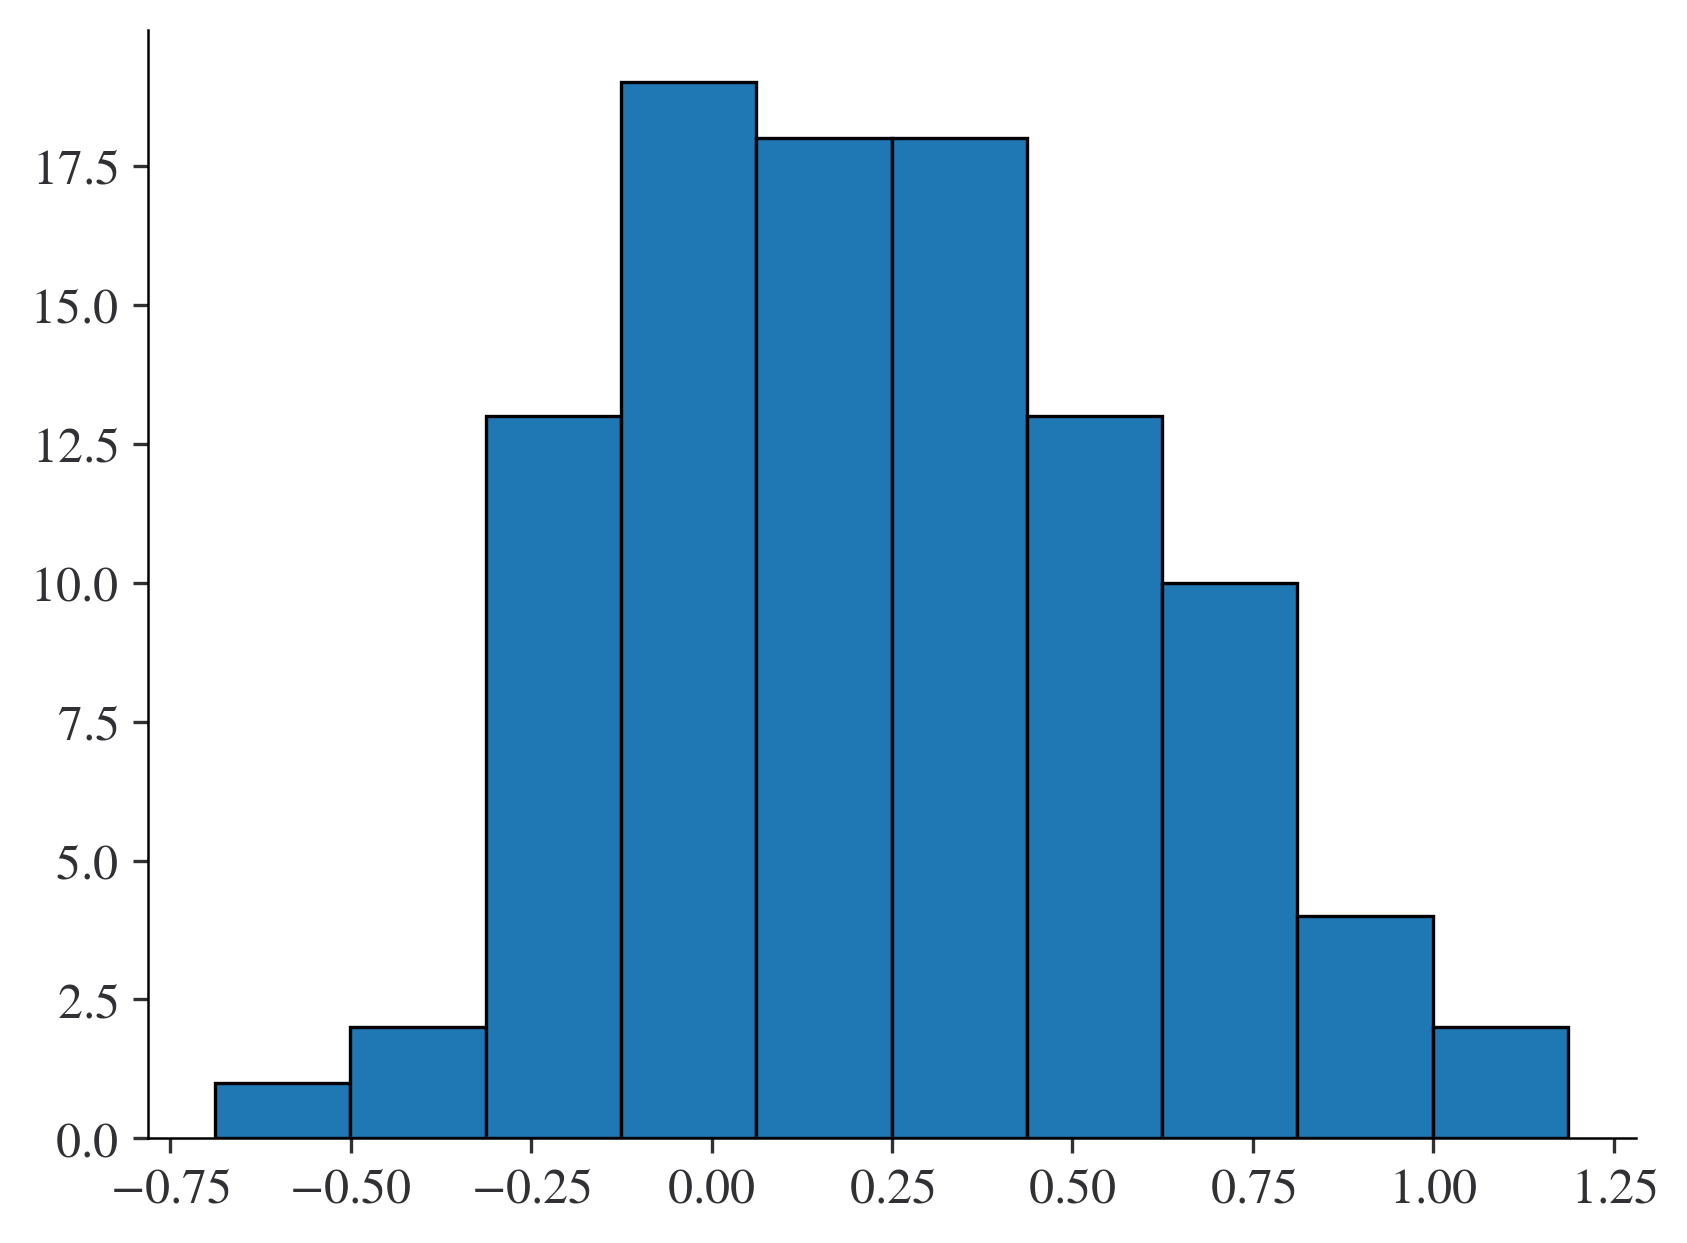

In [ ]:
plt.hist(l_array_MSTME[0]-l_array_original[0])

In [ ]:
i=10
MSTME_pctile = []
for i in range(len(l_array_MSTME)):
  pctile = ECDF(l_array_MSTME[i])(l_array_original[i])[0]
  MSTME_pctile.append(pctile)
# plt.hist(l_array_MSTME[i])
# plt.axvline(l_array_original[i])

In [ ]:

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

Text(0.0, 1.0, 'Visual example of how bias/variance is being calculated')

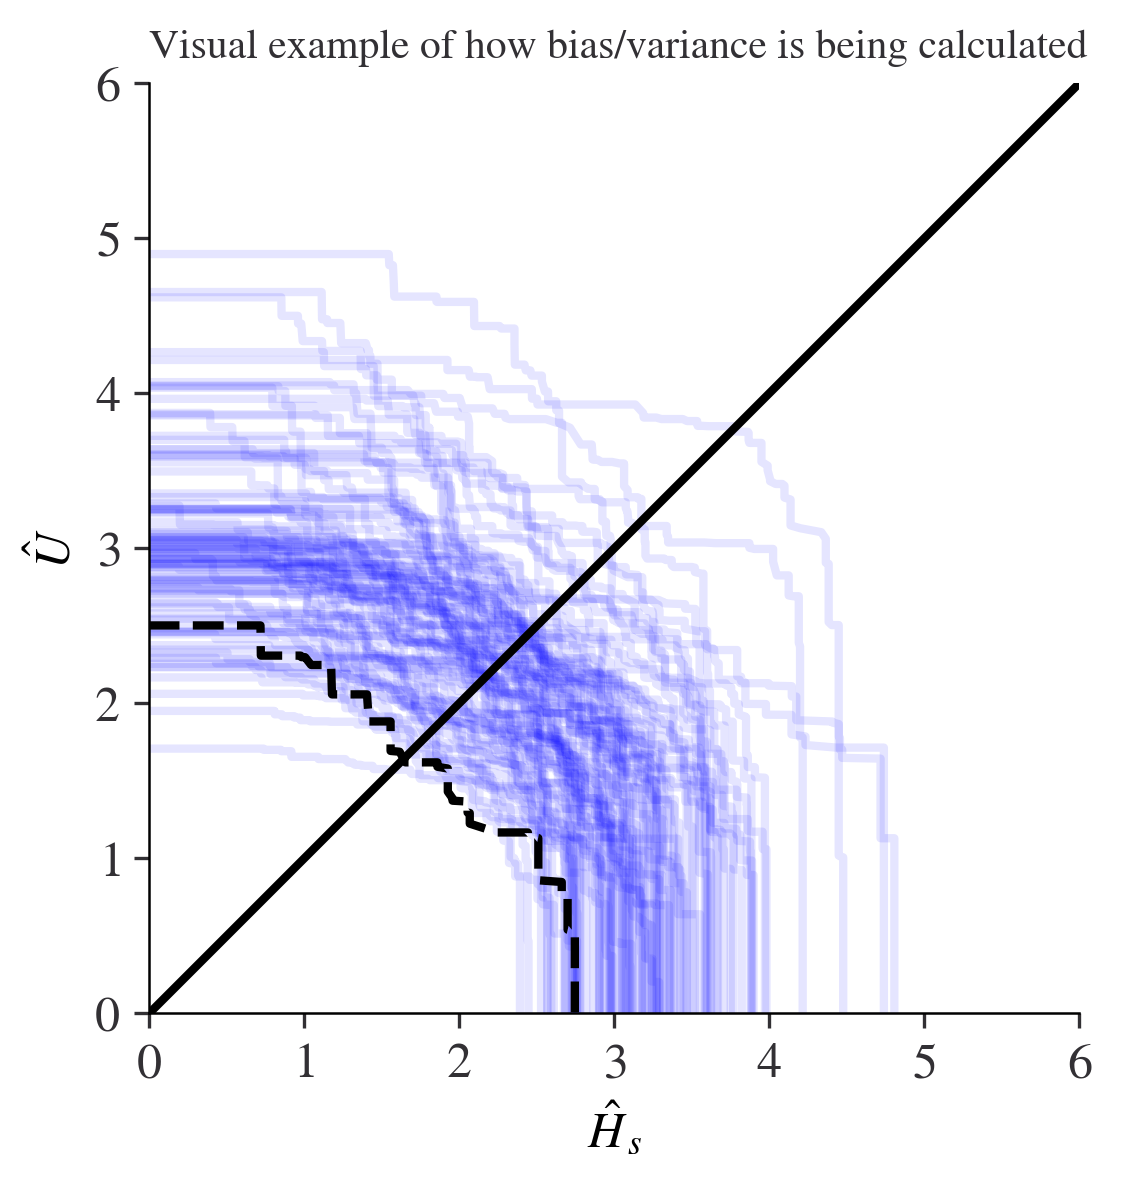

In [ ]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(4 , 6),
    facecolor="white",
)
ax.set_xlim(0,6)
ax.set_ylim(0,6)
ax.set_aspect('equal')
for ct in ic_MSTME:
    ax.plot(ct[0],ct[1],c='blue',alpha=0.1)
ax.plot([-10,10],[-10,10],c='black')
ax.plot(ic_original[0],ic_original[1],c='k',linestyle='--')
ax.set_xlabel(STM.H.name_norm())
ax.set_ylabel(STM.U.name_norm())
ax.set_title("Visual example of how bias/variance is being calculated",size=10)

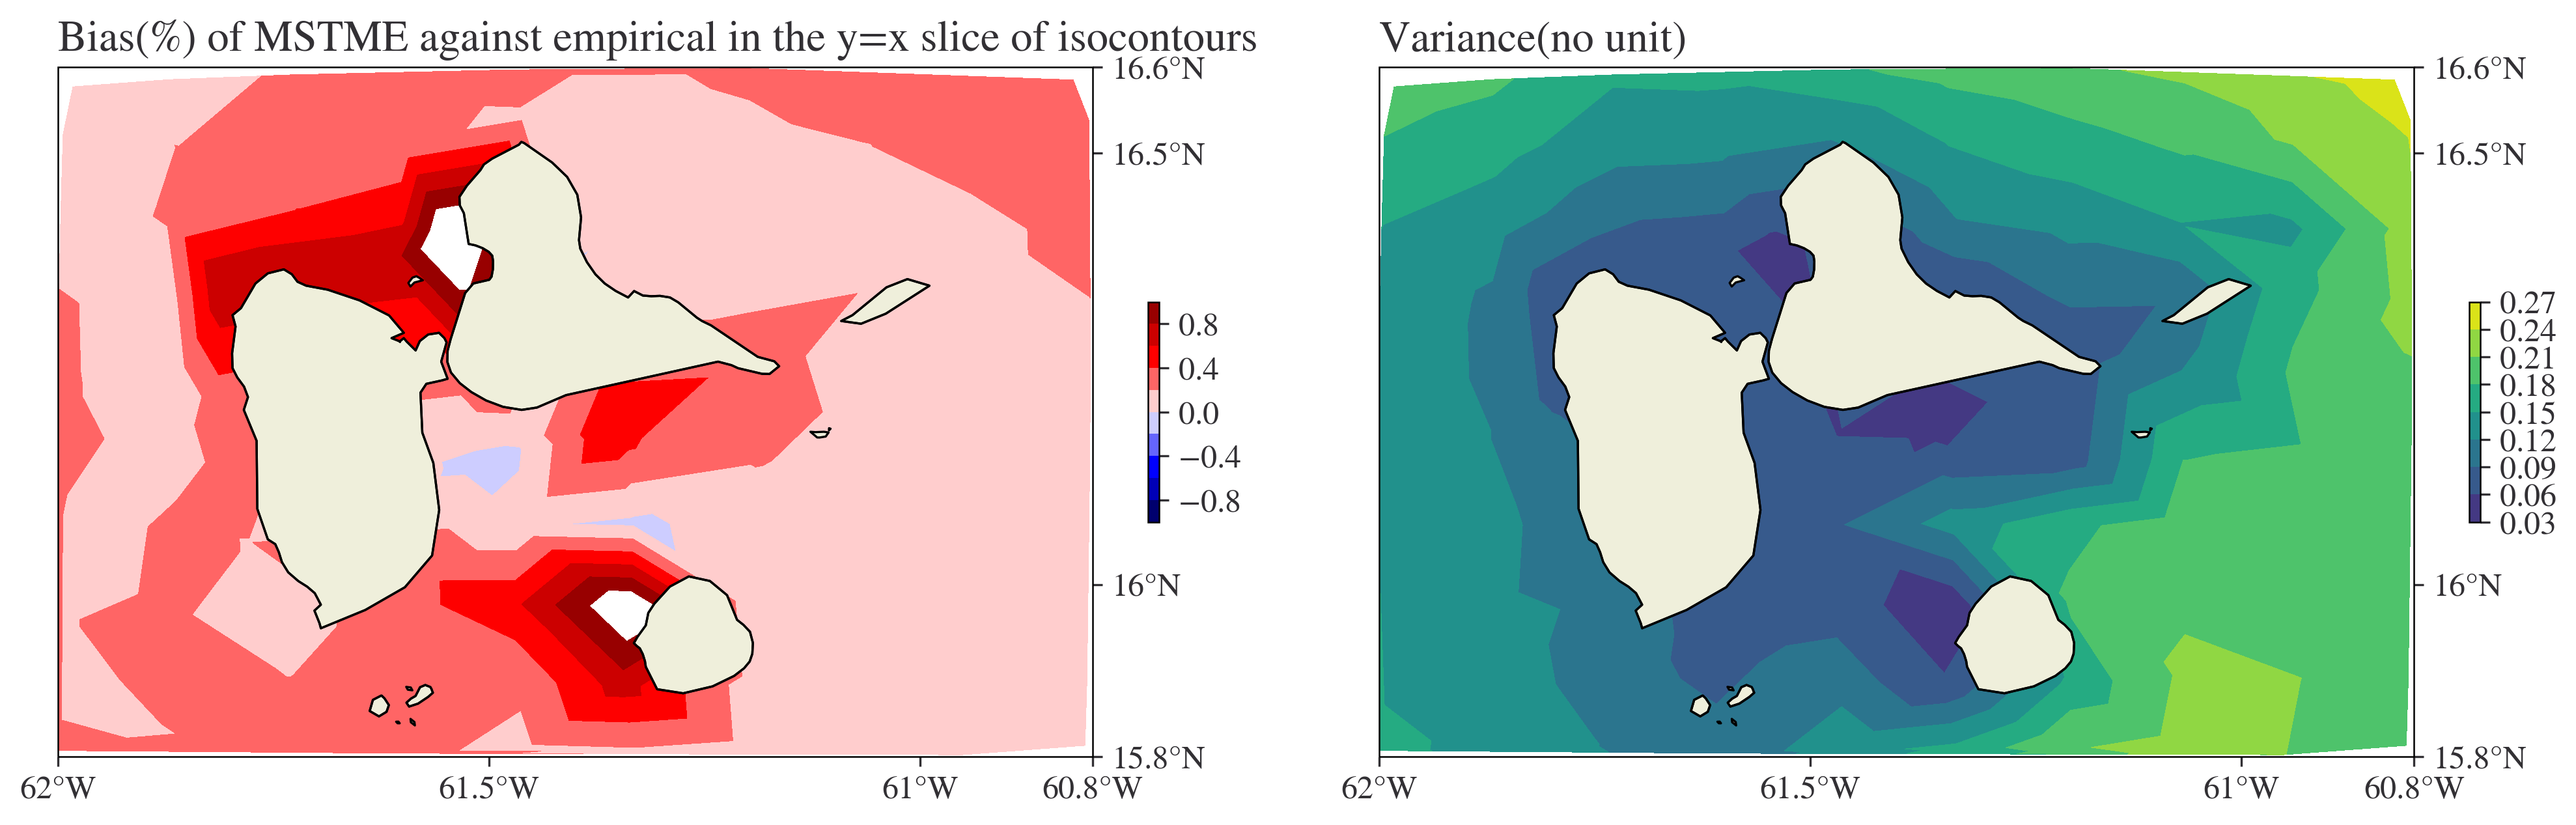

In [ ]:
fig, ax = plt.subplots(
    1,
    2,
    figsize=(8 * 2, 6 * 2),
    facecolor="white",
    subplot_kw={"projection": ccrs.PlateCarree()},
)
ax[0].set_title(f"Bias(%) of MSTME against empirical in the y=x slice of isocontours")
ax[0].set_xlim(area.min_lon, area.max_lon)
ax[0].set_ylim(area.min_lat, area.max_lat)
im0 = ax[0].tricontourf(
  mstme.latlon[pos_list, 1],
  mstme.latlon[pos_list, 0],
  # bias_MSTME,
  bias_MSTME_pct,
  # MSTME_pctile,
  cmap="seismic",
  levels=np.linspace(-1,1,11),
  # vmax=1,
  # vmin=0,
  zorder=-99,
)
ax[0] = grapher.custom_map(ax[0],cluster.area)

ax[1].set_title(f"Variance(no unit)")
ax[1].set_xlim(area.min_lon, area.max_lon)
ax[1].set_ylim(area.min_lat, area.max_lat)
im1 = ax[1].tricontourf(
  mstme.latlon[pos_list, 1],
  mstme.latlon[pos_list, 0],
  var_MSTME,
  vmin=0,
  zorder=-99,
)
ax[1] = grapher.custom_map(ax[1],cluster.area)
# fig.tight_layout()
# add_colorbar(im0)
plt.colorbar(im0,ax=ax[0],fraction=0.01)
plt.colorbar(im1,ax=ax[1],fraction=0.01)